<a href="https://colab.research.google.com/github/agroimpacts/VegMapper/blob/devel-calval/create_trainref_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Sample Sizes for Land Cover Assessement

This notebook walks through steps to calculate sample size and download sample points to assess accuracy of a land cover strata layer. 

In our example, we will be calculating sample sizes for presence and absence of oil palm fields in Ucayali, Peru. The notebook can calculate reference sample sizes, or reference + training/validation sample sizes. 

This notebook requires the following files/information:
- A land cover strata file listing classes of **presence** and **absence** for the category of interest. The file should be a Google Earth Engine (GEE) image asset of integer type. 
- A list of categories for **presence** and **absence**
- Required sampling parameters (described below)
- A Google Drive account for exporting the final shapefile and CSV files.

The final sample points are exported in Collect Earth Online (CEO) format.

# Overview of Steps

0. Set project options
1. Upload strata layer
2. Display centered strata layer. Print strata values, and relative areas.
3. Calculate reference sample size
4. Include Training/Validation requirements
5. Distribute sample points among sub-classes
6. Perform sampling.
7. Display samples over strata (all classes). Print out # of samples per class to confirm. 
8. Export samples to Google Drive.
9. Import CSV from Google Drive, and reformat to CEO format.
10. Export reformatted CSV in CEO format.

### Workflow Diagram

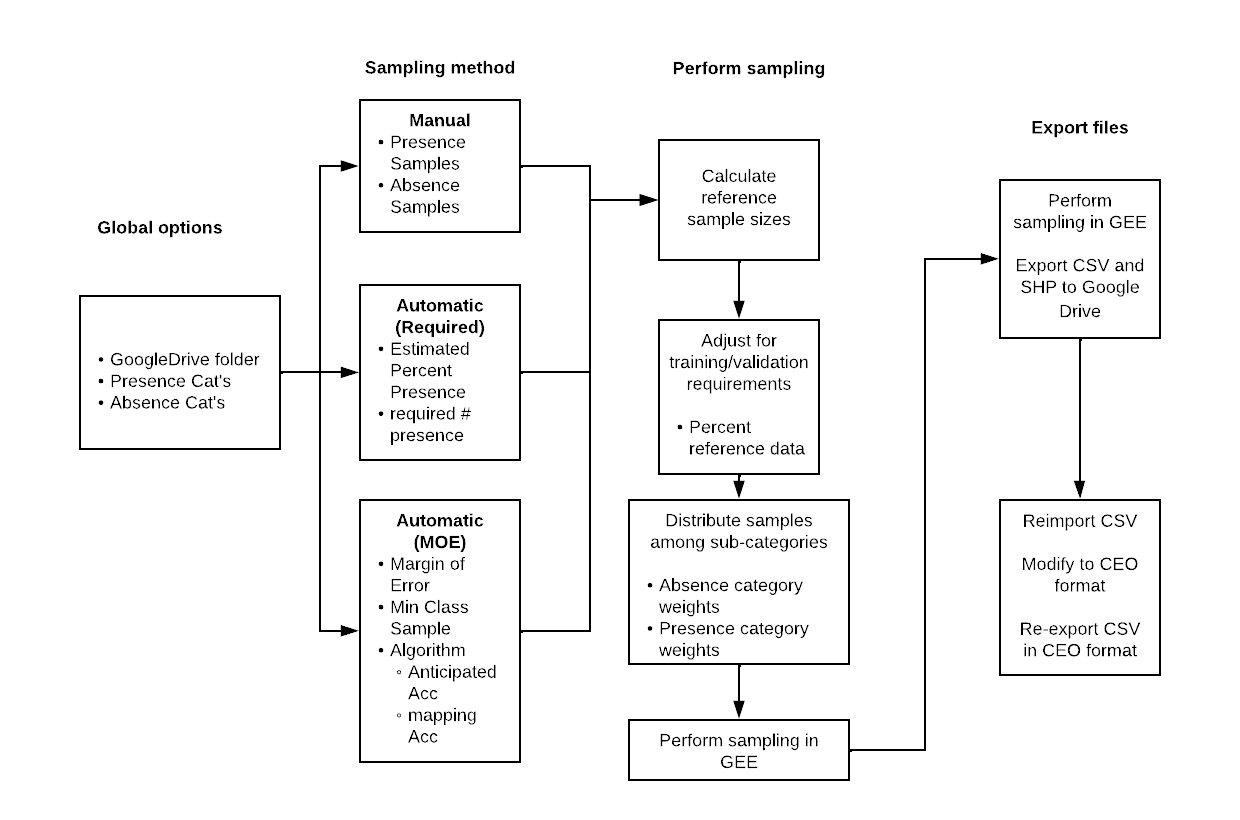

# Earth Engine Python API Colab Setup

Several libraries are required to be loaded to run this notebook. 

In addition, you need to authenticate your Google account to load data from Google Earth Engine (GEE).



### Import API and get credentials

These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

Run the following cell to import the API into your session.

In [48]:
import ee
import subprocess

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import geetools
except ImportError:
    print('geetools package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geetools'])

import geemap
import geetools
import pprint
import pandas as pd
import numpy as np
from numpy.ma.core import sqrt
from scipy.stats import norm
import time 
from google.colab import drive
import json 
from datetime import datetime as dt

### Authenticate GEE account.

Run the following cell to authenticate your GEE account. You will need to click through several screens, allow access to your Google account, and then copy and paste your **Authorization code**, and press Enter.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Set **googleDriveFolder** for exporting files. The code below also mounts the Google Drive, please allow permission.


In [ ]:
googleDriveFolder = 'samplePts'

## mount your Google Drive to access files
drive.mount('/content/drive')

# 0. Set Project Options

### General Options

Set **strataPath** to Earth Engine strata layer (an Image object of integer type). You can find this path by importing the image into a GEE script.

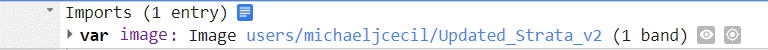

Set **presenceCats** and **absenceCats** to the image values for presence and absence categories. Other categories will be ignored.

You can also set the **randomSeed** variable to adjust the random seed used for assigning a random order to sample points, and selecting sample point locations.



In [51]:
#strataPath = 'users/michaeljcecil/Updated_Strata_v2'
strataPath = 'users/michaeljcecil/ucayali_oil_palm'

presenceCats= [1, 2]
absenceCats= [0]

randomSeed = 100

### Distribute samples among sub-categories.

The notebook calculates sample size for presence and absence regions. However, you may wish to specify how the presence and absence samples are distributed among sub-categories (i.e. among **presenceCats** and **absenceCats**)

- If **distributeSamples** is "False", then presence and absence samples are distributed equally among sub-categories.

- If **distributeSamples** is "True", then you can designate weights for how presence and absence samples should be distributed. 

For example, let's say your presence categories are 1 and 2, and you want to distribute 30 % of presence samples to category 1, and 70% to category 2. Then you would set **presenceCats = [1, 2]** and **presenceSampleWeights = [0.3, 0.7]**

Note that **presenceSampleWeights** must be the same length as **presenceCats**. (similar for **absenceSampleWeights** and **absenceCats**)



In [52]:
distributeSamples = True

presenceSampleWeights = [0.3, 0.7] ## must be same length as presenceCats
absenceSampleWeights = [1] ## must be same length as absenceCats

### Sampling methods

This notebook allows three options for calculating sample size. 

1.   Manually assign class sample sizes -- **"Manual"**
2.   Calculate sample sizes statistically based on desired margin of error (MOE) for class accuracy. **"Automatic_MOE"**
3.   Calculate sample sizes based on required number of presence samples. **"Automatic_RequiredNumber"**

In the box below, set sampleMethod to one of:

*   **"Manual"**
*   **"Automatic_MOE"**
*   **"Automatic_RequiredNumber"**

In [53]:
#sampleMethod = "Manual"
sampleMethod = "Automatic_MOE"
#sampleMethod = "Automatic_RequiredNumber"

### sampleMethod - "Manual"

Designate number of presence and absence reference samples. 


In [54]:
presenceSamples = 2500
absenceSamples = 700

### sampleMethod - "Automatic_RequiredNumber"

In this method, you designate the number of samples required for the reference presence set (**requiredTruePresence**). You also designate the estimated percent presence within the presence strata layer (**estimatedPercentPresenceTarget**). Finally, you designate the number of required absence samples (**requiredNumberAbsenceSamples**).

For example, imagine you require 1000 presence samples. Based on your knowledge of the strata presence layer, you expect that 60% of pixels in strata presence layer represent true presence. You also require 1000 absence samples. In this case, you set
- requiredTruePresence = 1000
- estimatedPercentPresenceTarget = 0.60
- requiredNumberAbsenceSamples = 1000

This example will result in 1,667 presence samples. 

In [ ]:
requiredTruePresence = 1000
estimatedPercentPresenceTarget = 0.60
requiredNumberAbsenceSamples = 1000

requiredNumberPresenceSamples = round(requiredTruePresence/estimatedPercentPresenceTarget)
print('total presence samples needed ', requiredNumberPresenceSamples)

### sampleMethod - "Automatic_MOE"

This method calculates sample sizes statistically. It assumes the user is trying to use samples to evaluate the accuracy of the presence and absence categories in the strata layer (user's accuracy). (see section 2.5 of [Stehman and Foody 2019](https://doi.org/10.1016/j.rse.2019.05.018))

In other words, these samples answer the question: *What percent of pixels designated presence (or absence) in the strata layer are actually presence (or absence)?*

To automatically calculate sample sizes, enter the following parameters below.

*   **MarginOfError**. The half-width of the confidence interval desired for the esimating user's accuracy. For example, a confidence interval for 80% accuracy with a margin of error of 0.02 would be (0.78, 0.82)
*   **ConfidenceLevel**. Generally the default confidence level of 0.95 is recommended.
*   **MinimumClassSample**. The minimum number of sample points in each class.
*   **sampleSizeAlgorithm**. Use **"StehmanFoody"** for calculating sample size related to confidence intervals for user's accuracies (most common case). The **"Oloffson"** option is described below. 
*   **anticipatedAcc**. The anticipated user's accuracies for presence and absence classes in the strata layer. If you are unsure, you can enter 0.5, which will result in the largest sample size. 



#### "Oloffson" algorithm.

This algorithm is used to calculate sample size when estimating the percent area represented by the presence class. In this case, set **sampleSizeAlgorithm** to **"Oloffson"**. In addition, you must designate **mappingAcc**, which represents the percent of pixels in the absence and presence classes that are actually presence. For example, if you expect 0.0001% of absence strata pixels to actually be presence, and 70% of presence strata pixels to actually be presence, then set **mappingAcc = [0.000001, 0.70]**  

More details are available here: https://www.openmrv.org/web/guest/w/modules/mrv/modules_3/sampling-design-for-estimation-of-area-and-map-accuracy .


In [56]:
MarginOfError = 0.07
ConfidenceLevel = 0.95
MinimumClassSample = 30

sampleSizeAlgorithm = "StehmanFoody" ## OR
##sampleSizeAlgorithm = "Oloffson" 

## For "StehmanFoody", designate the estimated user's accuracies of the strata layer for absence and presence
anticipatedAcc = [0.90, 0.7]

## For "Oloffson", designate the percent of pixels for [absence, presence] expected to be in presence class
mappingAcc = [0.000000001, 0.7]

### Adding Training/Validation Data

If you only wish to calculate a reference sample, then set **referencePctOfTotal = 1**

However, if you wish to download training/validation data in addition to the reference sample, then set referencePctOfTotal to the percent of all data represented by the reference sample.

For example, if the reference sample points represent 10% of all sample points, and training/validation represents 90% of all sample points, then set **referencePctOfTotal = 0.1**

In [57]:
referencePctOfTotal = 0.2

# 1. Import strata layer

Your strata layer can be imported directly from a Google Earth Engine (GEE) asset, or from Google Drive. 

The code below imports from a GEE asset, creating an image layer "strata", which contains land cover information from Ucayali, Peru. 

In [ ]:
# Add Earth Engine asset
strata = ee.Image(strataPath)
strataInfo = strata.getInfo()
strata = strata.rename(['category'])	

## band names
strata_reduced = strata.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                                maxPixels = 9999999999)
strata_hist = ee.Dictionary(strata_reduced).get(strata.bandNames().get(0)).getInfo()
band_values = list(strata_hist.keys()) 
print("band values: ", band_values )
band_values_int = [int(float(string)) for string in band_values]
print(band_values_int)
print("number of unique values: ", len(band_values) )
band_values_min = min(band_values_int)
band_values_max = max(band_values_int)
print("min band value: ", band_values_min)
print("max band value: ", band_values_max)
## CRS
print("CRS: ", strataInfo['bands'][0]['crs'])
## dimensions
print("dimensions: ", strataInfo['bands'][0]['dimensions'] )
## resolution
scale = strata.projection().nominalScale().getInfo();
print("spatial resolution: ", scale)
## bbox
bbox = strata.geometry().bounds().getInfo()['coordinates'][0]
print("bounding box: ",  bbox)

# 2. Display strata and calculate strata area

The code below displays a map centered on the strata layer, and calculates the area (in pixels) and proportion of each strata value. 

In [ ]:
Map = geemap.Map(center=(40, -100), zoom=4)

## qualtitative palette (max 12 categories)
qualPalette = ['a6cee3', '1f78b4', 'b2df8a', '33a02c', 'fb9a99', 'e31a1c', 'fdbf6f', 'ff7f00', 'cab2d6', '6a3d9a', 'ffff99', 'b15928']

#Specify the min and max labels and the color palette matching the labels.
vizParamsStrata = {'min': band_values_min, 'max': band_values_max, 'palette': qualPalette}

Map.addLayer(strata, vizParamsStrata, "Strata")
Map.centerObject(strata)

strata_reduced = strata.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                                maxPixels = 9999999999)

strata_hist = ee.Dictionary(strata_reduced).get(strata.bandNames().get(0)).getInfo()
print(strata_hist)

strata_df = pd.DataFrame(strata_hist.items(), columns=['Cat', 'pixel_ct'])
strata_df['Cat'] = strata_df['Cat'].astype(np.float16).astype(np.int16).astype(str)
#print(pd.to_numeric(strata_df['Cat']))
total_area = strata_df['pixel_ct'].sum()
print("total area: ",total_area, " pixels")
strata_df['pct_area'] = round(strata_df['pixel_ct']* 100/total_area, 3)


print(strata_df.to_string(index=False))

Map

# 2a. Set up binary classes

This code calculates area statistics after consolidating the presence and absence categories.

In the consolidated categories, 0 represents absence and 1 represents presence.

In [ ]:
strata_df_original = strata_df.copy()

presenceCatsCount = (strata_df_original[strata_df_original['Cat'].isin(map(str, presenceCats))])['pixel_ct'].sum()
absenceCatsCount = (strata_df_original[strata_df_original['Cat'].isin(map(str, absenceCats))])['pixel_ct'].sum()

strata_df = pd.DataFrame({'Cat' : ['0', '1']})
strata_df['pixel_ct'] = [absenceCatsCount, presenceCatsCount]
strata_df['pct_area'] = round(strata_df['pixel_ct']* 100/total_area, 3)

print("")
print("data frame after combining classes:")
print(strata_df)

# 3. Calculate reference sample size

The next two blocks of code calculate the reference sample sizes based on the **sampleMethod** and other sampling parameters.

In this example, we are using the **"Automatic_MOE"** method with the **"StehmanFoody"** algorithm.

The final sample sizes are listed in the "nh_adjusted" column. There are 30 absence samples and 2017 presence samples.

In [ ]:
CategoryOfInterest = 1 ## set category of interest to "presence"

if sampleMethod == "Manual":
  print("Manual")
  strata_df['nh_adjusted'] = [absenceSamples, presenceSamples]

elif sampleMethod == "Automatic_RequiredNumber":
  print("Automatic Required Number")
  strata_df['nh_adjusted'] = [requiredNumberAbsenceSamples, requiredNumberPresenceSamples]

elif sampleMethod == "Automatic_MOE":
  print("Automatic MOE")
  strata_df['qh'] = mappingAcc
  strata_df['wh'] =   strata_df['pct_area'] /100
  strata_df['SDh'] = (strata_df['qh'] * (1 - strata_df['qh']))**(1/2)
  strata_df['SDh_x_wh'] = strata_df['SDh'] * strata_df['wh']

  z_score = norm.ppf(1-((1-ConfidenceLevel)/2))
  print(z_score)
  pct_area_cat_of_interest = float((strata_df[strata_df['Cat'] == str(CategoryOfInterest)])['pct_area'])
  print(pct_area_cat_of_interest)

  if sampleSizeAlgorithm == "StehmanFoody":
    print("Stehman Foody")
    strata_df['p'] = anticipatedAcc
    d = MarginOfError
    print(strata_df)
    strata_df['nh'] = ((z_score**2)*strata_df['p']*(1-strata_df['p']))/d**2
    strata_df['nh_adjusted'] = strata_df['nh'].apply(lambda x: max(x, MinimumClassSample)) 

  elif sampleSizeAlgorithm == "Oloffson" :
    print("Oloffson")
    target_SE = MarginOfError * ((pct_area_cat_of_interest/100)/z_score)
    print(target_SE)

    n = ((strata_df['SDh_x_wh'].sum())/target_SE)**2
    print('total sample size ', n)
    strata_df['nh'] = round(strata_df['wh'] * n) ## NOTE THAT OLOFFSON METHOD distributes based on area
    strata_df['nh_adjusted'] = strata_df['nh'].apply(lambda x: max(x, MinimumClassSample)) 

  else: 
    print("invalid sample size algorithm")

else:
  print("invalid sample method: ", sampleMethod)


In [ ]:
sampleSizes = strata_df['nh_adjusted'].to_numpy().round().astype(int)
sampleSizesRef = sampleSizes.copy()
print('sample sizes ', sampleSizes)
print('sample sizes ref', sampleSizesRef)

print(strata_df) 
print("final sample sizes:")
strata_df_sel = strata_df[['Cat','nh_adjusted']]
print(strata_df_sel.to_string(index = False))

# 4. Include Training/Validation requirements

This code adjusts sample size based on training/validation requirements.

In [ ]:
print("reference sample sizes: ", sampleSizesRef.tolist())
sampleSizes = (sampleSizesRef / referencePctOfTotal).round().astype(int)
np.set_printoptions(suppress=True)
print("adjusted sample sizes: ", sampleSizes.tolist())


# 5. Distribute sample points among sub-classes

This code distributes the absence and presence samples among sub-categories, based on the **absenceSampleWeights** and **presenceSampleWeights** parameters.

In this example, there are 300 absence samples distributed among the original strata categories "4" and "5", with weights 0.3 and 0.7 respectively. As a result, the distributed absence samples are 90 for category 4 and 210 for category 5.

Similarly, the 20,170 presence samples are distributed as 8068 for category 1 and 12,102 for category 2.

In [ ]:
totalSampleSizeAbsence = sampleSizes[0]
totalSampleSizePresence = sampleSizes[1]

numClassesAbsence = len(absenceCats)
numClassesPresence = len(presenceCats)

# print(sampleSizes)

if distributeSamples == False:
  sampleSizeAbsence = [round(totalSampleSizeAbsence/ (1.0 * numClassesAbsence))]* numClassesAbsence
  sampleSizePresence = [round(totalSampleSizePresence/ (1.0 * numClassesPresence))]* numClassesPresence
#  print(sampleSizeAbsence)
#  print(sampleSizePresence)
  
if distributeSamples == True:
  totalAbsenceWeights = sum(absenceSampleWeights)
  totalPresenceWeights = sum(presenceSampleWeights)
  sampleSizeAbsence = [x * ((1/totalAbsenceWeights) * totalSampleSizeAbsence) for x in absenceSampleWeights]
  sampleSizePresence = [x * ((1/totalPresenceWeights) * totalSampleSizePresence) for x in presenceSampleWeights]
#  print(sampleSizeAbsence)
 # print(sampleSizePresence)
  
# add column with placeholder values
strata_df_original['nh_final'] = -9999

## set sample sizes for presence classes
for k in range(len(presenceCats)):
# print(presence_class)
  presence_class = presenceCats[k]
#  print(presence_class)
  sampleSizeClass = sampleSizePresence[k]
 # print(sampleSizeClass)
  class_index = strata_df_original.index[strata_df_original['Cat'] == str(presence_class)].tolist()
#  print(class_index)
  strata_df_original['nh_final'][class_index]  = sampleSizeClass

## set sample sizes for absence classes
for k in range(len(absenceCats)):
# print(presence_class)
  absence_class = absenceCats[k]
  sampleSizeClass = sampleSizeAbsence[k]
  class_index = strata_df_original.index[strata_df_original['Cat'] == str(absence_class)].tolist()
  strata_df_original['nh_final'][class_index]  = sampleSizeClass


## adjust any NA fields to have 0 samples
strata_df_original.loc[strata_df_original['nh_final'] < 0, "nh_final"] = 0
print(strata_df_original)
sampleSizesAllocated = round(strata_df_original['nh_final']).to_numpy().astype(int)
print("")
print("sample sizes by class:")
print(sampleSizesAllocated)
print("")

# 6. Perform Sampling in GEE

This code uses the GEE API to calculate the location of all sample points. 

These points are then displayed in a map, with presence samples in <font color='red'>**red**</font> and absence samples in <font color='blue'>**blue**</font>.

In [ ]:
totalSamples = int(sampleSizesAllocated.sum())
print("total samples: ", [totalSamples])
classValues = strata_df_original['Cat'].to_numpy().astype(int).tolist()
print("class values: ", classValues)
classPoints = sampleSizesAllocated.tolist()
print("desired class points: ", classPoints)
classBand = strata.bandNames().get(0).getInfo()
#print(classBand)
totalSamplesList = [totalSamples]
totalSamplesNum = int(totalSamples)

## perform stratified sample in GEE

samples = strata.stratifiedSample(
  numPoints= totalSamples,
  classBand= classBand,
  projection= 'EPSG:3857',
  classValues= ee.List(classValues),
  classPoints= ee.List(classPoints),
  geometries= True,
  scale= 30,
  seed= randomSeed,
  tileScale= 1)

#print(samples.getInfo())
samples_presence = samples.filter(ee.Filter.inList(classBand, presenceCats))
samples_absence = samples.filter(ee.Filter.inList(classBand, absenceCats))
#print(samples_presence.getInfo())

vizParamsPres = {"color": 'FF0000'} ## red
vizParamsAbs = {"color": '0000FF'} ## blue

Map = geemap.Map(center=(40, -100), zoom=4)
## qualtitative palette (max 12 categories)
qualPalette = ['a6cee3', '1f78b4', 'b2df8a', '33a02c', 'fb9a99', 'e31a1c', 'fdbf6f', 'ff7f00', 'cab2d6', '6a3d9a', 'ffff99', 'b15928']

#Specify the min and max labels and the color palette matching the labels.
vizParamsStrata = {'min': band_values_min, 'max': band_values_max, 'palette': qualPalette}

#print(vizParamsStrata)

Map.addLayer(strata, vizParamsStrata, "Strata")
Map.centerObject(strata)
Map.addLayer(samples_presence, vizParamsPres, 'presence')
Map.addLayer(samples_absence, vizParamsAbs, 'absence')
Map.addLayerControl()
Map


# 7. Confirm # of samples per category

This code iterates through each class of the original strata layer and prints the number of points per class. 

**Note that some if a category does not have enough pixels to meet the sample size requirements, then there may be fewer sample points for this category.**

In [ ]:
print(classValues)
print('total # samples: ', samples.size().getInfo())

for class_level in classValues:
  print("")
  print('category: ', class_level)
  filtered_samplePts = samples.filter(ee.Filter.eq(classBand, class_level))
  print("size: ", filtered_samplePts.size().getInfo())

# 8. Export samples to Google Drive

This code exports the sample points to your Google Drive folder. The points are exported as a shapefile "sample_points_SHP", and as a CSV file "sample_points_CSV". 

The "Polling for task" message displays every 5 seconds. Once it stops displaying, your files should be ready. 

In [ ]:
## Export sample files to SHP and CSV

timestamp = dt.now().strftime("%Y_%m_%d_%H%M%S")
print("current time: " + timestamp)
export_file_name_shp = 'sample_points_SHP_' + timestamp
export_file_name_csv = 'sample_points_CSV_' + timestamp

#Randomize Sample Order
randomcolumn = samples.randomColumn(**{
    'seed': randomSeed})

shuffle = randomcolumn.sort('random');
 
#Export Shuffled Points
task1 = ee.batch.Export.table.toDrive(**{
  'collection': shuffle,
  'description': export_file_name_shp,
  'fileFormat': 'SHP',
  'folder': googleDriveFolder
})
task1.start()

 #Export Shuffled Points
task2 = ee.batch.Export.table.toDrive(**{
  'collection': shuffle,
  'description': export_file_name_csv,
  'fileFormat': 'CSV',
  'folder': googleDriveFolder

})
task2.start()

while task1.active():
  print('Polling for task (id: {}).'.format(task1.id))
  time.sleep(5)

while task2.active():
  print('Polling for task (id: {}).'.format(task2.id))
  time.sleep(5)

print('finished exporting')

# 9. Convert to CEO format

This code reimports the files from Google Drive and formats them in Collect Earth Online (CEO) format. 

You need to allow Google Drive to access your files.

In [169]:
from importlib import reload  # Py3 only; unneeded in py2.
drive = reload(drive)

## mount your Google Drive to access files
#drive.mount('/content/drive')

In [ ]:
sample_pts_df = pd.read_csv('/content/drive/My Drive/' + googleDriveFolder + '/sample_points_CSV_' + timestamp + '.csv', index_col=False)

sample_pts_df.sort_values(by=['random'], inplace=True)

sample_pts_df['PLOTID']  = sample_pts_df['system:index'] + 1
sample_pts_df['LON'] = sample_pts_df['.geo'].apply(lambda x: (json.loads(x))['coordinates'][0] )
sample_pts_df['LAT'] = sample_pts_df['.geo'].apply(lambda x: (json.loads(x))['coordinates'][1] )
sample_pts_df.insert(0, 'SAMPLEID', range(1, 1 + len(sample_pts_df)))

sample_pts_df_CEO_w_class = sample_pts_df[['PLOTID', 'LON', 'LAT', 'SAMPLEID', 'random', classBand]]
#print(sample_pts_df_CEO_w_class)

sample_pts_df_CEO_no_class = sample_pts_df[['PLOTID', 'LON', 'LAT', 'SAMPLEID', 'random']]

print(sample_pts_df_CEO_w_class)
### get rid of column A. sort by random, renumber PLOTID based on random... 
### make CEO account, upload CSV to test... create project etc.. can choose what imagery is shown for labeling. 

# 10. Export reformatted CSV in CEO format.

Finally, export the CEO formatted files. Two files are exported. 
- The "CEO_w_class.csv" file includes the original strata category as a column.
- The "CEO_no_class.csv" file does not include the original category.

In [171]:
# Write the DataFrame to CSV file.
with open('/content/drive/My Drive/' + googleDriveFolder + '/sample_points_CEO_w_class_' + timestamp + '.csv', 'w') as f:
  sample_pts_df_CEO_w_class.to_csv(f, float_format='{:f}'.format, encoding='utf-8', index = False)

with open('/content/drive/My Drive/' + googleDriveFolder + '/sample_points_CEO_no_class_' + timestamp + '.csv', 'w') as f:
  sample_pts_df_CEO_no_class.to_csv(f, float_format='{:f}'.format, encoding='utf-8', index = False)

print('files exported')

files exported
